In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import shutil
import random


## Preparing the Dataset

In [34]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
image_size = (224,224)
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir = '/kaggle/input/new-plant-diseases-dataset/test/test'
# Define the new base directory structure
base_output_dir = '/kaggle/working/dataset'
output_train_dir = os.path.join(base_output_dir, 'train')
output_valid_dir = os.path.join(base_output_dir, 'valid')
output_test_dir = os.path.join(base_output_dir, 'test')

# Create the output directories
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_valid_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)

# Copy the training set
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):  # Ensure it's a directory
        # Create the class directory in the output train directory
        output_class_path = os.path.join(output_train_dir, class_folder)
        os.makedirs(output_class_path, exist_ok=True)
        
        # Copy all images to the new class directory
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if os.path.isfile(img_path):  # Ensure it's a file
                shutil.copy(img_path, output_class_path)

# Copy the validation set
for class_folder in os.listdir(valid_dir):
    class_path = os.path.join(valid_dir, class_folder)
    if os.path.isdir(class_path):  # Ensure it's a directory
        # Create the class directory in the output valid directory
        output_class_path = os.path.join(output_valid_dir, class_folder)
        os.makedirs(output_class_path, exist_ok=True)
        
        # Copy all images to the new class directory
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if os.path.isfile(img_path):  # Ensure it's a file
                shutil.copy(img_path, output_class_path)


print("Dataset has been reorganized and moved to /kaggle/working/dataset")

Dataset has been reorganized and moved to /kaggle/working/dataset


In [37]:
train_dir = '/kaggle/working/dataset/train'
valid_dir = '/kaggle/working/dataset/valid'
test_dir = '/kaggle/working/dataset/test'

os.makedirs(test_dir, exist_ok=True)

split_ratio = 0.2 


for class_name in os.listdir(valid_dir):
    class_valid_dir = os.path.join(valid_dir, class_name)
    class_test_dir = os.path.join(test_dir, class_name)

    os.makedirs(class_test_dir, exist_ok=True)

    images = [f for f in os.listdir(class_valid_dir) if os.path.isfile(os.path.join(class_valid_dir, f))]
    
    random.shuffle(images)
    num_test_images = int(len(images) * split_ratio)
    test_images = images[:num_test_images]

    for image in test_images:
        src_path = os.path.join(class_valid_dir, image)
        dest_path = os.path.join(class_test_dir, image)
        shutil.move(src_path, dest_path)

    print(f"Moved {len(test_images)} images from '{class_valid_dir}' to '{class_test_dir}'")

Moved 91 images from '/kaggle/working/dataset/valid/Cherry_(including_sour)___healthy' to '/kaggle/working/dataset/test/Cherry_(including_sour)___healthy'
Moved 95 images from '/kaggle/working/dataset/valid/Corn_(maize)___Northern_Leaf_Blight' to '/kaggle/working/dataset/test/Corn_(maize)___Northern_Leaf_Blight'
Moved 82 images from '/kaggle/working/dataset/valid/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot' to '/kaggle/working/dataset/test/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
Moved 96 images from '/kaggle/working/dataset/valid/Tomato___healthy' to '/kaggle/working/dataset/test/Tomato___healthy'
Moved 99 images from '/kaggle/working/dataset/valid/Pepper,_bell___healthy' to '/kaggle/working/dataset/test/Pepper,_bell___healthy'
Moved 96 images from '/kaggle/working/dataset/valid/Grape___Esca_(Black_Measles)' to '/kaggle/working/dataset/test/Grape___Esca_(Black_Measles)'
Moved 85 images from '/kaggle/working/dataset/valid/Tomato___Bacterial_spot' to '/kaggle/working/d

In [38]:

train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    seed=42,
    class_mode='categorical'
)

# Load validation data
validation_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

Found 70295 images belonging to 38 classes.
Found 14069 images belonging to 38 classes.
Found 3503 images belonging to 38 classes.


## Building The Model With EfficientNet

In [39]:
# EfficientNetB0 as base model (without top layer)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(38, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
model = models.Model(inputs=base_model.input, outputs=predictions)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,           
    patience=3,           
    min_lr=1e-6           
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   
    patience=5,            
    restore_best_weights=True 
)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_18[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,724,937 (18.02 MB)

 Trainable params: 675,366 (2.58 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Training

In [40]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=130,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/130
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 194s 74ms/step - accuracy: 0.0894 - loss: 4.3426 - val_accuracy: 0.6376 - val_loss: 3.1152 - learning_rate: 1.0000e-05
Epoch 2/130
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 135s 61ms/step - accuracy: 0.3624 - loss: 3.2272 - val_accuracy: 0.7707 - val_loss: 2.1904 - learning_rate: 1.0000e-05
Epoch 3/130
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 128s 58ms/step - accuracy: 0.5183 - loss: 2.5545 - val_accuracy: 0.8262 - val_loss: 1.7306 - learning_rate: 1.0000e-05
Epoch 4/130
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 131s 59ms/step - accuracy: 0.6089 - loss: 2.1593 - val_accuracy: 0.8530 - val_loss: 1.4921 - learning_rate: 1.0000e-05
Epoch 5/130
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 131s 60ms/step - accuracy: 0.6633 - loss: 1.9204 - val_accuracy: 0.8726 - val_loss: 1.3432 - learning_rate: 1.0000e-05
Epoch 6/130
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 128s 58ms/step - accuracy: 0.7040 - loss: 1.7430 - val_accuracy: 0.8847 - val_loss: 1.2408 - learning_rate: 1.0000e-05
Epoch 7/130
2197/2197 ━━━━━━

## Evaluation on Test dataset

In [41]:
def evaluate_model(model, dataset):
    results = model.evaluate(dataset)
    print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

# Evaluate on validation set
evaluate_model(model, test_generator)

110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.9550 - loss: 0.4129
Test Loss: 0.4147786796092987, Test Accuracy: 0.9528974890708923


In [43]:
class_names = list(train_generator.class_indices.keys())
print("Training dataset class names:", class_names)


Training dataset class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spi

In [44]:
import os
test_dir_images = "/kaggle/input/new-plant-diseases-dataset/test/test"
test_images = sorted(os.listdir(test_dir_images))

## Prediction result from the test images

In [60]:
import numpy as np
def predict_image(img_path, model):
    
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100
    
    return class_names[predicted_class], confidence

for img_name in test_images:
    img_path = os.path.join(test_dir_images, img_name)
    predicted_label = predict_image(img_path, model)
    print('Label:', img_name, ', Predicted:', predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Label: AppleCedarRust1.JPG , Predicted: ('Apple___Cedar_apple_rust', 89.83412981033325)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Label: AppleCedarRust2.JPG , Predicted: ('Apple___Cedar_apple_rust', 98.23268055915833)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Label: AppleCedarRust3.JPG , Predicted: ('Apple___Cedar_apple_rust', 85.75012683868408)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Label: AppleCedarRust4.JPG , Predicted: ('Apple___Cedar_apple_rust', 99.07888770103455)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Label: AppleScab1.JPG , Predicted: ('Apple___Apple_scab', 88.06296586990356)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Label: AppleScab2.JPG , Predicted: ('Apple___Apple_scab', 94.20241117477417)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Label: AppleScab3.JPG , Predicted: ('Apple___Apple_scab', 61.76813244819641)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Label: CornCommonRust1.JPG , Predicted: ('Corn_(maize)___Common_rust_', 99.7648537158966)
1/1 ━━━━━━━━━━━━━━━━━━━

### shows that out of 33 images, 30 is correct and 3 is wrong 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


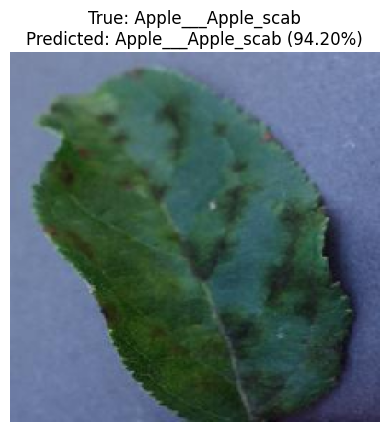

In [61]:
import matplotlib.pyplot as plt


def plot_image_with_prediction(img_path, true_label, model):
    predicted_label, confidence = predict_image(img_path, model)
    
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    
    plt.imshow(img)
    plt.axis('off')
    
    plt.title(f"True: {true_label}\nPredicted: {predicted_label} ({confidence:.2f}%)")
    plt.show()


test_image_path = os.path.join(test_dir_images, test_images[5])
true_label = "Apple___Apple_scab"  # Replace with actual label for the image

plot_image_with_prediction(test_image_path, true_label, model)

In [49]:

model.save("/kaggle/working/Plant_disease_detection_Efficientnet.h5")


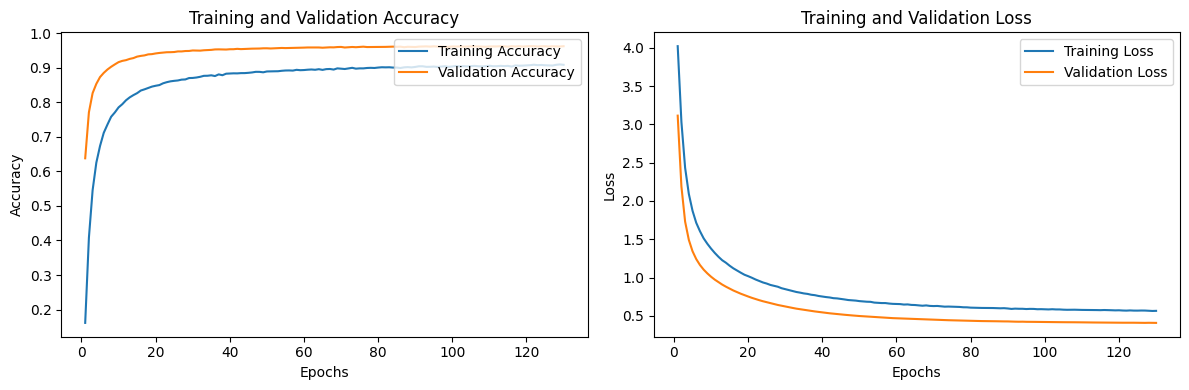

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [58]:
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
    
download_file('/kaggle/working/Plant_disease_detection_Efficientnet.h5', 'out')

/kaggle/working/out.zip